In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
# Import the data
disposals = pd.read_csv('disposal_csv-uwisconsin(in).csv')

# Change device names to be more readable
device_location_map = {
    'uwisconsin_madison_oscarsort_1': 'U South',
    'uwisconsin_madison_oscarsort_2': 'Dejope',
    'uwisconsin_madison_oscarsort_3': 'Mem U',
    'uwisconsin_madison_oscarsort_4': 'Gordon Dining'
}
disposals['Device'] = disposals['Device'].map(device_location_map)


disposals.head()

,Date,Device,Bin,Item,Disposals,Contaminants,Correct Bin
0,1/7/2025,U South,Trash,plastic gloves,2,0,Trash
1,1/7/2025,Dejope,Trash,apple core,1,0,Trash
2,1/7/2025,Mem U,Trash,plastic wrap,1,0,Trash
3,1/14/2025,U South,Recycling,tetrapack,1,1,Trash
4,1/14/2025,U South,Recycling,wrapper,1,1,Trash


## Analyze the Qualities of Each Column



In [74]:
column_names = disposals.columns
print(column_names)

Index(['Date', 'Device', 'Bin', 'Item', 'Disposals', 'Contaminants',
       'Correct Bin'],
      dtype='object')


### Date
The day that the disposal took place

In [75]:
date_min = disposals['Date'].min()
date_max = disposals['Date'].max()
print(len(disposals['Date']), date_min, date_max)

2504 1/14/2025 4/8/2025


### Device
The Oscar device that the disposal was made in
(1: U South, 2: Dejope, 3: Mem U, 4: Gordon Dining)

In [76]:
print(len(disposals['Device']), disposals['Device'].unique())

2504 ['U South' 'Dejope' 'Mem U' 'Gordon Dining']


### Bin
The bin that the disposal was placed in

In [77]:
print(len(disposals['Bin']), disposals['Bin'].unique())

2504 ['Trash' 'Recycling']


### Item
The type of item that was disposed of

In [78]:
len(disposals['Item']), disposals['Item'].unique()

(2504,
 array(['plastic gloves', 'apple core', 'plastic wrap', 'tetrapack',
        'wrapper', 'plastic cutlery', 'plastic bottle', 'food box',
        'napkin', 'plastic bag', 'plastic lid', 'plastic container',
        'coffee cup lid', 'coffee cup', 'plastic sauce cup',
        'plastic straw', 'plastic cup', 'coffee cup sleeve',
        'paper wrapper', 'paper', 'chopsticks', 'food scraps',
        'aluminium can', 'soft plastic lid', 'paper pop cup', 'liquids',
        'paper bag', 'banana peel', 'paper bowl', 'orange peel',
        'cardboard', 'waxed food paper', 'yoghurt container', 'face mask',
        'stirstick', 'paper plate', 'chip bag', 'paper plastic bag',
        'receipt', 'aluminium foil', 'aluminium container', 'glass bottle',
        'sauce packet', 'aluminium bottle', 'coffee creamer cup',
        'paper lid', 'pizza box', 'paper sauce cup', 'paper drink tray',
        'battery', 'magazine', 'wooden cutlery', 'tea bag', 'apple scraps',
        'juice pouch'], dtype

### Disposals
The number of times that item was disposed in that device's bin on that date

In [79]:
print(len(disposals['Disposals']), disposals['Disposals'].min(), disposals['Disposals'].mean(), disposals['Disposals'].max())

2504 1 4.378194888178914 67


### Contaminants
If the item was placed in the right bin, contaminants = 0. If placed in the wrong bin, contaminants = disposals

In [80]:
print(len(disposals['Contaminants']), disposals['Contaminants'].min(), disposals['Contaminants'].mean(), disposals['Contaminants'].max())

2504 0 1.4404952076677315 47


### Correct Bin
The type of bin that the item belongs in when disposed of correctly

In [81]:
print(len(disposals['Correct Bin']), disposals['Correct Bin'].unique())

2504 ['Trash' 'Recycling']


**TODO**: Plot trends over time, Bring in waste audit data, Perform exploratory statistics

## Plotting Trends

### Disposals Over Time

<Axes: title={'center': 'Total Disposals Per Day'}, xlabel='Date'>

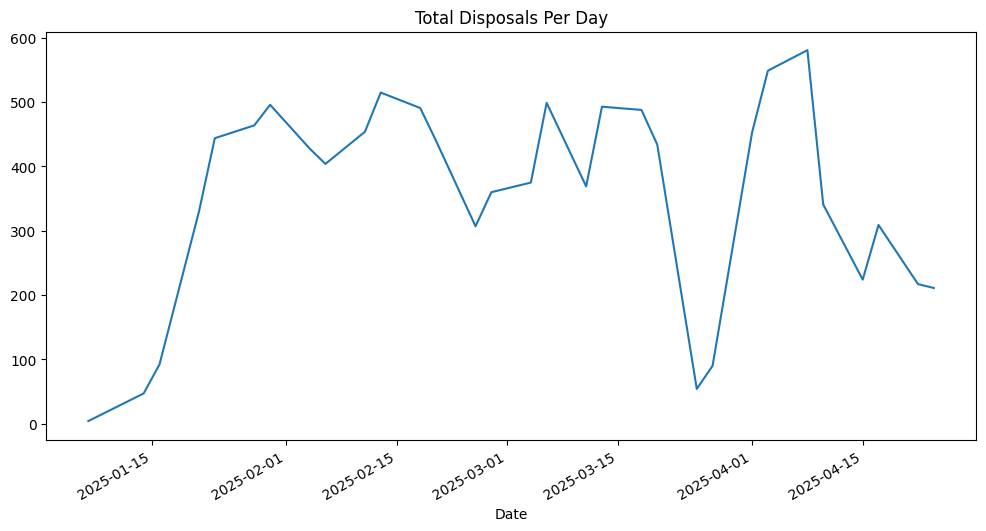

In [82]:
disposals['Date'] = pd.to_datetime(disposals['Date'])

total_disposals_per_day = disposals.groupby('Date')['Disposals'].sum()
total_disposals_per_day.plot(kind='line', figsize=(12, 6), title='Total Disposals Per Day')

### Contaminants Over Time

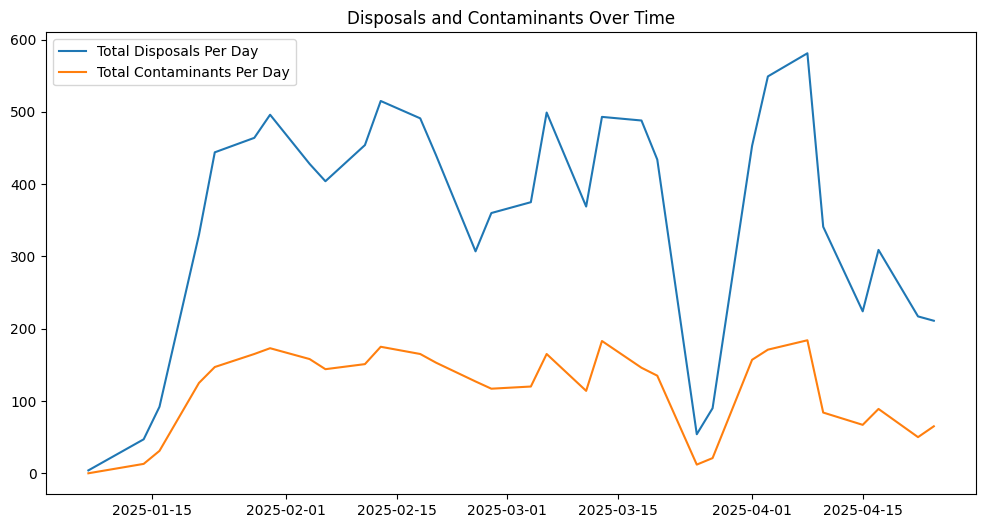

In [83]:
plt.figure(figsize=(12, 6))
total_contaminants_per_day = disposals.groupby('Date')['Contaminants'].sum()

plt.plot(total_disposals_per_day.index, total_disposals_per_day.values, label='Total Disposals Per Day')
plt.plot(total_contaminants_per_day.index, total_contaminants_per_day.values, label='Total Contaminants Per Day')
plt.title('Disposals and Contaminants Over Time')
plt.legend()
plt.show()

### Frequencies of Items Disposed

Item
napkin               2302
plastic cutlery      1201
plastic container    1192
food box              756
wrapper               752
Name: Disposals, dtype: int64


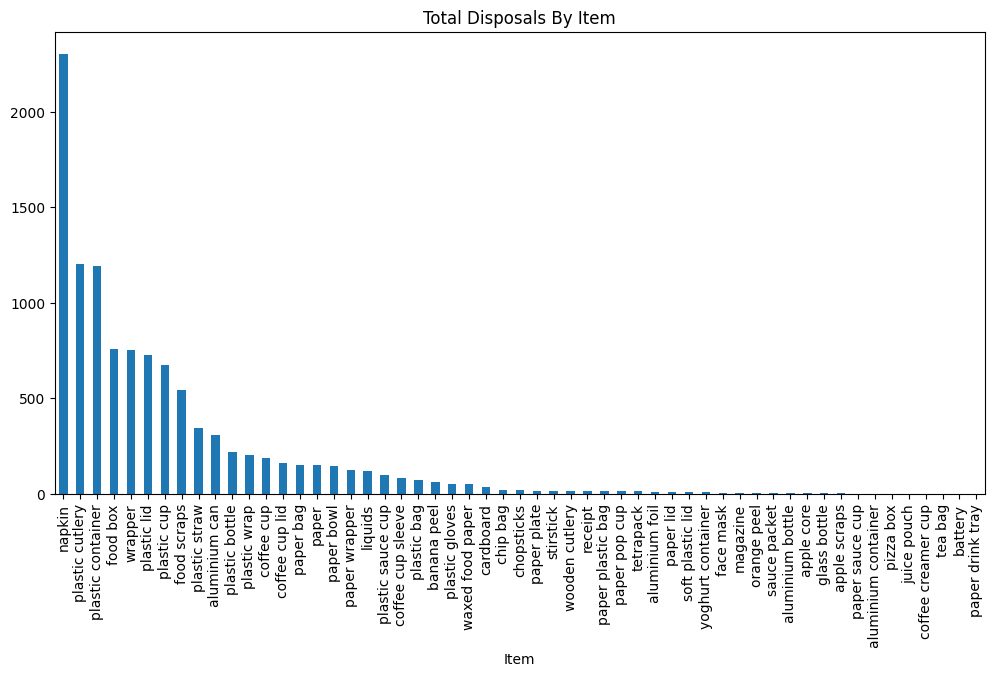

In [84]:
item_freqs = disposals.groupby('Item')['Disposals'].sum().sort_values(ascending=False)
item_freqs.plot(kind='bar', figsize=(12, 6), title='Total Disposals By Item')
print(item_freqs.head(5))

Item
plastic container    1026
plastic lid           578
plastic cup           504
napkin                289
plastic cutlery       161
Name: Contaminants, dtype: int64


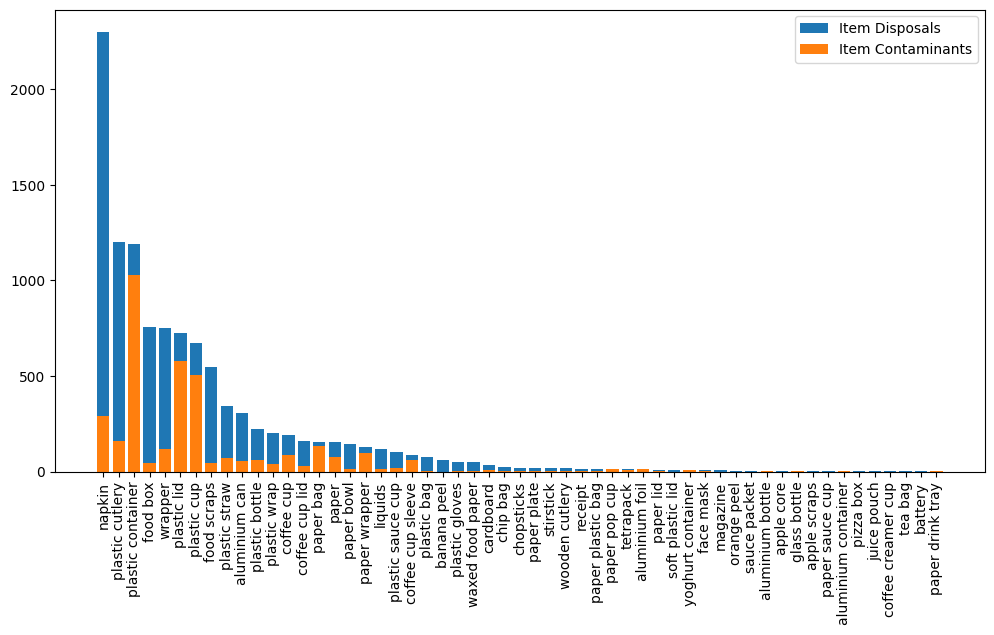

In [85]:
item_contaminant_freqs = disposals.groupby('Item')['Contaminants'].sum().sort_values(ascending=False)
print(item_contaminant_freqs.head(5))

plt.figure(figsize=(12, 6))
plt.bar(item_freqs.index, item_freqs.values, label='Item Disposals')
plt.bar(item_contaminant_freqs.index, item_contaminant_freqs.values, label='Item Contaminants')

x = np.arange(len(item_freqs.index))
plt.xticks(x, item_freqs.index, rotation=90)

plt.legend()
plt.show()

Item
paper drink tray     100.000000
glass bottle         100.000000
aluminium foil        91.666667
paper bag             87.662338
plastic container     86.073826
dtype: float64


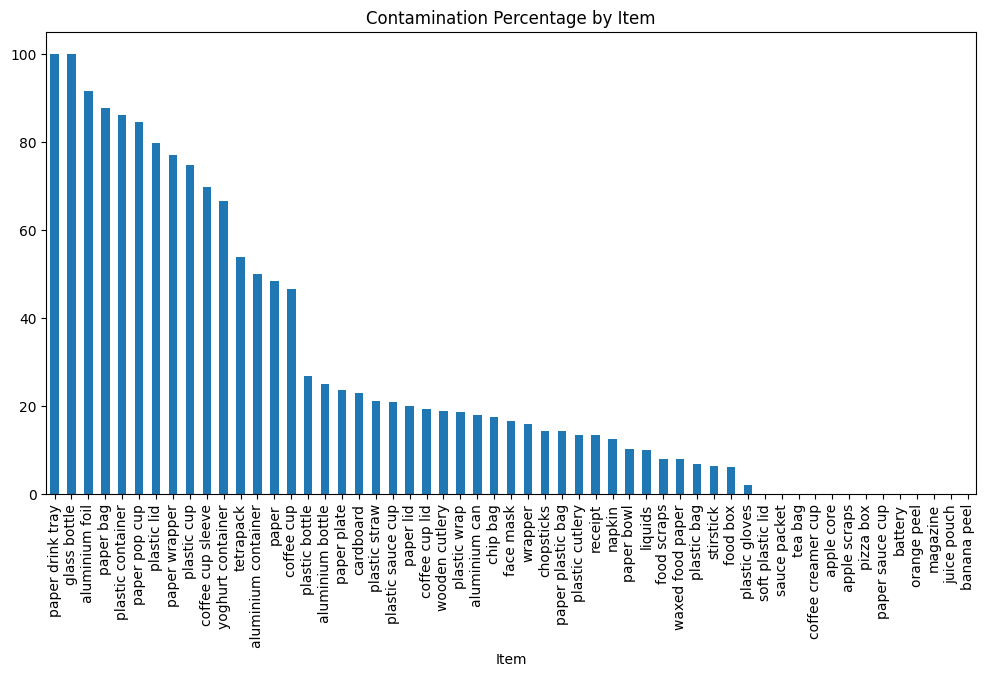

In [86]:
contamination_percentage = (item_contaminant_freqs / item_freqs * 100).sort_values(ascending=False)
contamination_percentage.plot(kind='bar', figsize=(12, 6), title='Contamination Percentage by Item')
print(contamination_percentage.head(5))

### Disposals by Device

Device
Gordon Dining    4343
U South          4317
Dejope           1812
Mem U             491
Name: Disposals, dtype: int64


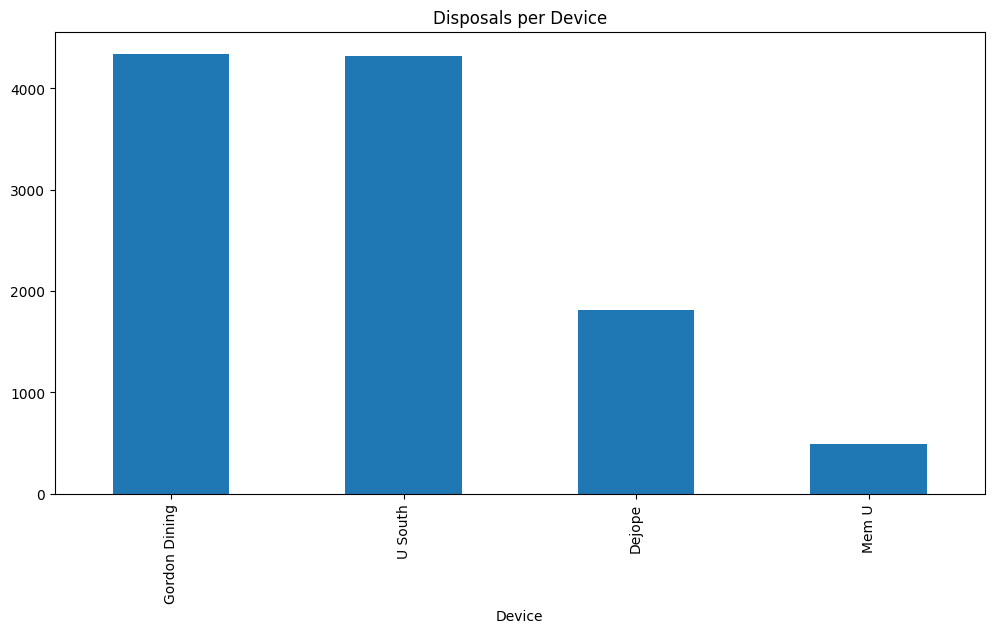

In [88]:
disposals_by_device = disposals.groupby('Device')['Disposals'].sum().sort_values(ascending=False)
disposals_by_device.plot(kind='bar', figsize=(12, 6), title='Disposals per Device')
print(item_freqs.head(4))

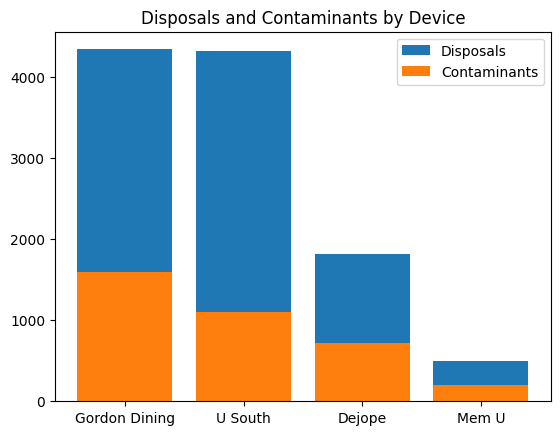

Device
Mem U            40.733198
Dejope           39.403974
Gordon Dining    36.587612
U South          25.573315
dtype: float64


In [92]:
contaminants_by_device = disposals.groupby('Device')['Contaminants'].sum().sort_values(ascending=False)

plt.bar(disposals_by_device.index, disposals_by_device.values, label='Disposals')
plt.bar(contaminants_by_device.index, contaminants_by_device.values, label='Contaminants')
plt.title('Disposals and Contaminants by Device')
plt.legend()
plt.show()

contamination_percentage_by_device = (contaminants_by_device / disposals_by_device * 100).sort_values(ascending=False)
print(contamination_percentage_by_device.head(4))

## Union South Waste Audit Data
Audit was performed in December 2024

In [93]:
audit = pd.read_csv('USouth_waste_audit.csv')
print(audit.head(5))

   Day       Type  Mass (lbs)  Total Recyclable (lbs)  \
0  Tue    Garbage      363.57                   16.50   
1  Wed    Garbage      257.53                   12.10   
2  Thu    Garbage       95.15                    4.30   
3  Tue  Recycling       55.98                   27.42   
4  Wed  Recycling       16.90                   11.50   

   Contamination Percentage  
0                      4.54  
1                      4.70  
2                      4.52  
3                     48.98  
4                     68.05  


In [94]:
# These numbers come directly from the waste audit report
total_usouth_recycle_contamination = 53.40
total_usouth_garbage_contamination = 4.59

In [97]:
usouth = disposals[disposals['Device'] == 'U South']

contamination_by_bin = (usouth.groupby('Bin')['Contaminants'].sum() / usouth.groupby('Bin')['Disposals'].sum()) * 100

contamination_percentages = pd.DataFrame({
    'Type': ['Recycling', 'Garbage', 'Recycling', 'Garbage'],
    'Source': ['Audit', 'Audit', 'Device', 'Device'],
    'Percentage': [53.40, 4.59, contamination_by_bin['Recycling'], contamination_by_bin['Trash']]

})

print(contamination_percentages.head())

        Type  Source  Percentage
0  Recycling   Audit   53.400000
1    Garbage   Audit    4.590000
2  Recycling  Device   41.597139
3    Garbage  Device   21.707878


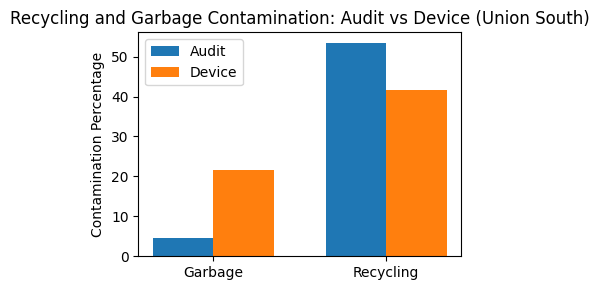

In [99]:
pivot_df = contamination_percentages.pivot(index='Type', columns='Source', values='Percentage')

# Set up bar positions
types = pivot_df.index
x = np.arange(len(types))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x - width/2, pivot_df['Audit'], width, label='Audit')
ax.bar(x + width/2, pivot_df['Device'], width, label='Device')

ax.set_ylabel('Contamination Percentage')
ax.set_title('Recycling and Garbage Contamination: Audit vs Device (Union South)')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend()
plt.tight_layout()
plt.show()